# Import and constants


In [1]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 4.9 MB/s 


In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
import visualkeras
from PIL import ImageFont
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16
IMAGE_SIZE = [176, 208]
EPOCHS = 30
class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
NUM_CLASSES = len(class_names)

Use of colab to run this notebook, therefore we need to import files in our google drive.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Saving the path to each original, downsampled and oversampled dataset.

In [5]:
path_origin_ds = r"/content/drive/MyDrive/Colab Notebooks/Alzheimer_s Dataset/"
path_dwn_samp_ds = r"/content/drive/MyDrive/Colab Notebooks/Downsampled_dataset/"
path_ovr_samp_ds = r"/content/drive/MyDrive/Colab Notebooks/Oversampled_dataset/"


## Definiton of functions

Definition of function to map each image to a vector of size 4 corresponding to the class of the vector (one hot encoding).
Definition of the function of the reverse process of one hot encoding.

In [6]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

def rev_one_hot_label(image, label):
    label = tf.argmax(label, axis = 1)
    return image, label

# Data preprocessing

## Loading the original dataset

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_origin_ds+"/train/",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_origin_ds+"/train/",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


Renaming the class

In [8]:
train_ds.class_names = class_names
val_ds.class_names = class_names

## Loading the downsampled dataset

In [9]:
dwn_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_dwn_samp_ds+"/train/",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

dwn_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_dwn_samp_ds+"/train/",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 2203 files belonging to 4 classes.
Using 1763 files for training.
Found 2203 files belonging to 4 classes.
Using 440 files for validation.


In [10]:
dwn_train_ds.class_names = class_names
dwn_val_ds.class_names = class_names

## Loading the oversampled dataset

In [11]:
ovr_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_ovr_samp_ds+"/train/",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

ovr_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_ovr_samp_ds+"/train/",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 6166 files belonging to 4 classes.
Using 4933 files for training.
Found 6166 files belonging to 4 classes.
Using 1233 files for validation.


In [12]:
ovr_train_ds.class_names = class_names
ovr_val_ds.class_names = class_names

# Visualize images loaded and one hot encoding

## Original dataset

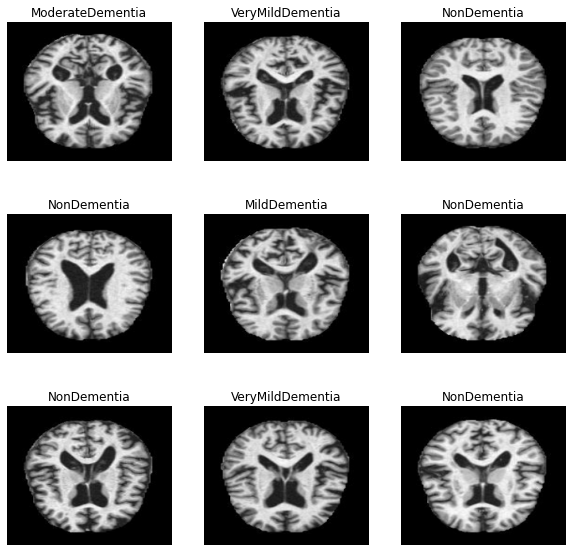

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

One hot encoding of the images

In [14]:
train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

Prefetching to make the call of the images more efficient

In [15]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Downsampled Dataset

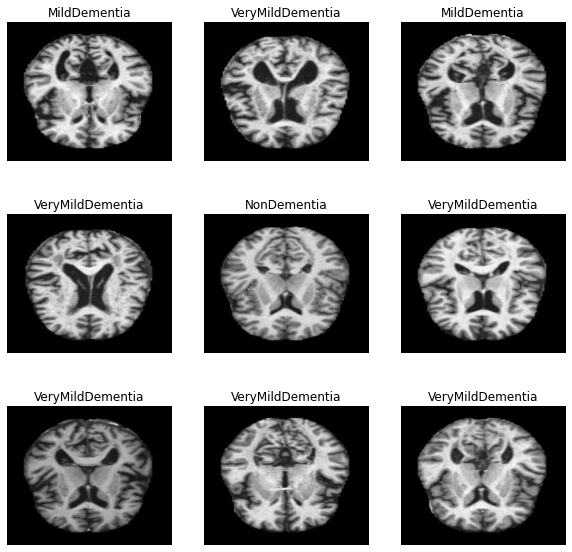

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in dwn_train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(dwn_train_ds.class_names[labels[i]])
    plt.axis("off")

In [17]:
dwn_train_ds = dwn_train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
dwn_val_ds = dwn_val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

In [18]:
dwn_train_ds = dwn_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
dwn_val_ds = dwn_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Oversampled Dataset

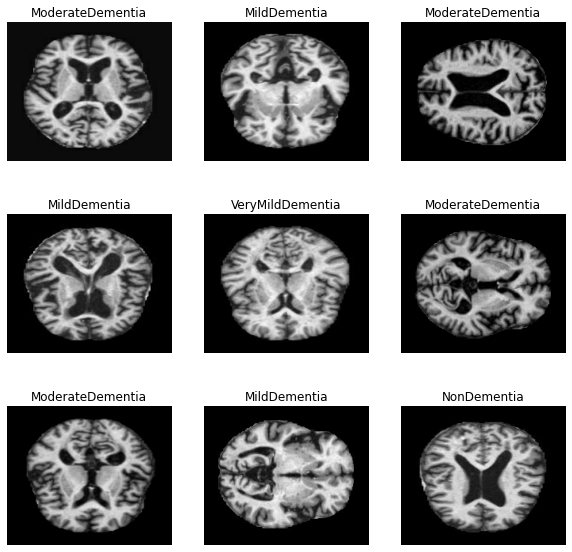

In [19]:
plt.figure(figsize=(10, 10))
for images, labels in ovr_train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(ovr_train_ds.class_names[labels[i]])
    plt.axis("off")

In [20]:
ovr_train_ds = ovr_train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
ovr_val_ds = ovr_val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

In [21]:
ovr_train_ds = ovr_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
ovr_val_ds = ovr_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Building a simple model

Define the simple machine learning model

In [22]:
def ml_model_simple():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),


        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
     
        
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

Set the metrics and the loss function and the model for each dataset

In [23]:

model_origin_ds_simple = ml_model_simple()
model_dwn_ds_simple = ml_model_simple()
model_ovr_ds_simple = ml_model_simple()

METRICS = [tf.keras.metrics.AUC(name='auc'),tf.keras.metrics.CategoricalAccuracy(name='acc')]

model_origin_ds_simple.compile(
    optimizer='adam',
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=METRICS
)
model_dwn_ds_simple.compile(
    optimizer='adam',
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=METRICS
)
model_ovr_ds_simple.compile(
    optimizer='adam',
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=METRICS
)

Use of the exponiantial decay as learning rate scheduler

In [24]:
def exp_decay(lr0, s):
    def exp_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exp_decay_fn

exp_decay_fn = exp_decay(0.01, 20)
lrng_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(exp_decay_fn)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("save_file.h5",save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

We can visualize the model as follow :

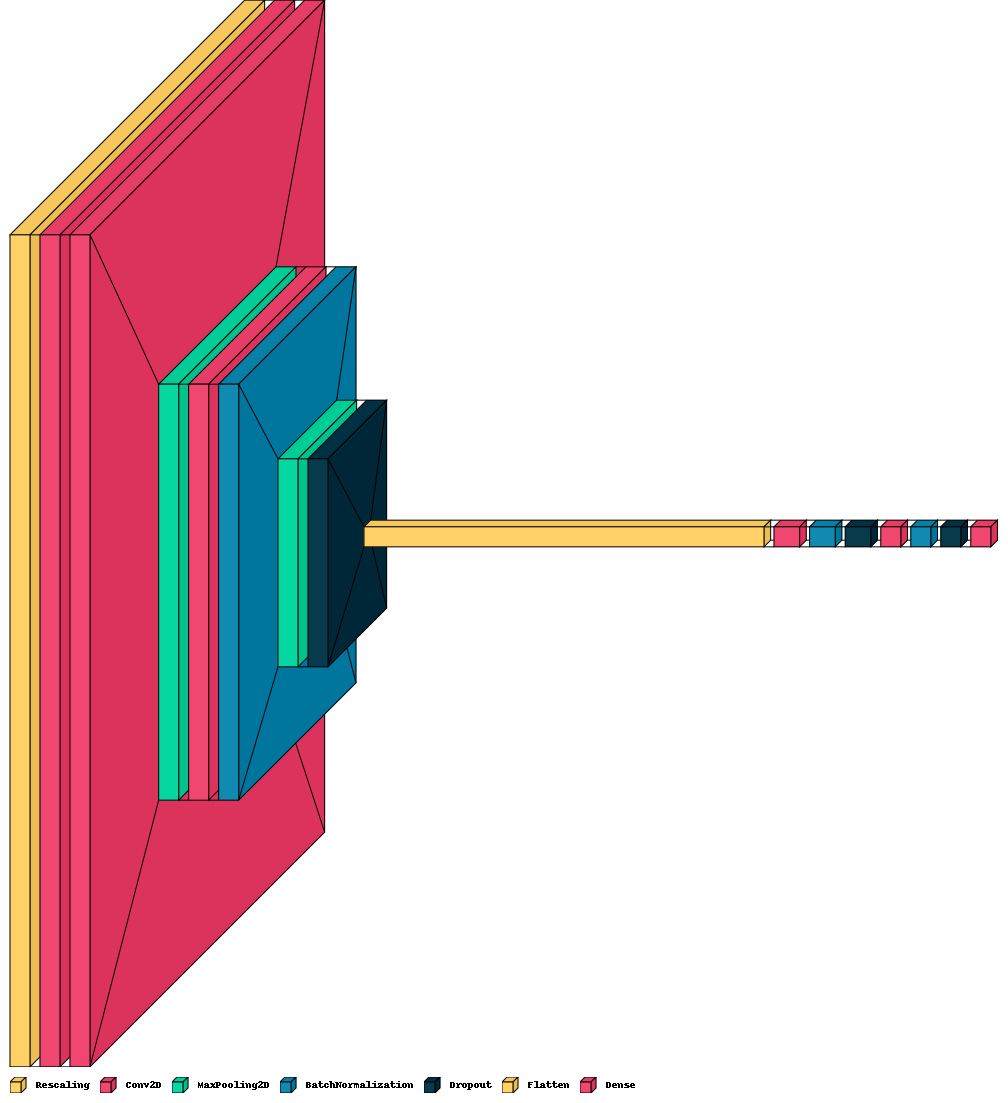

In [36]:
visualkeras.layered_view(model_origin_ds_simple, legend=True) 

# Building a more complexe model

Define the complexe machine learning model

In [ ]:
def ml_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),

        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),

        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

Set the metrics and the loss function and the model for each dataset

In [ ]:

model_origin_ds = ml_model()
model_dwn_ds = ml_model()
model_ovr_ds = ml_model()

METRICS = [tf.keras.metrics.AUC(name='auc'),tf.keras.metrics.CategoricalAccuracy(name='acc')]

model_origin_ds.compile(
    optimizer='adam',
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=METRICS
)
model_dwn_ds.compile(
    optimizer='adam',
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=METRICS
)
model_ovr_ds.compile(
    optimizer='adam',
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=METRICS
)

Use of the exponiantial decay as learning rate scheduler

In [ ]:
def exp_decay(lr0, s):
    def exp_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exp_decay_fn

exp_decay_fn = exp_decay(0.01, 20)
lrng_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(exp_decay_fn)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("save_file.h5",save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
model_origin_ds.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 176, 208, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 176, 208, 16)      448       
                                                                 
 conv2d_13 (Conv2D)          (None, 176, 208, 16)      2320      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 88, 104, 16)      0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 88, 104, 32)       4640      
                                                                 
 batch_normalization_15 (Bat  (None, 88, 104, 32)      128       
 chNormalization)                                     

We can visualize the model as follow :

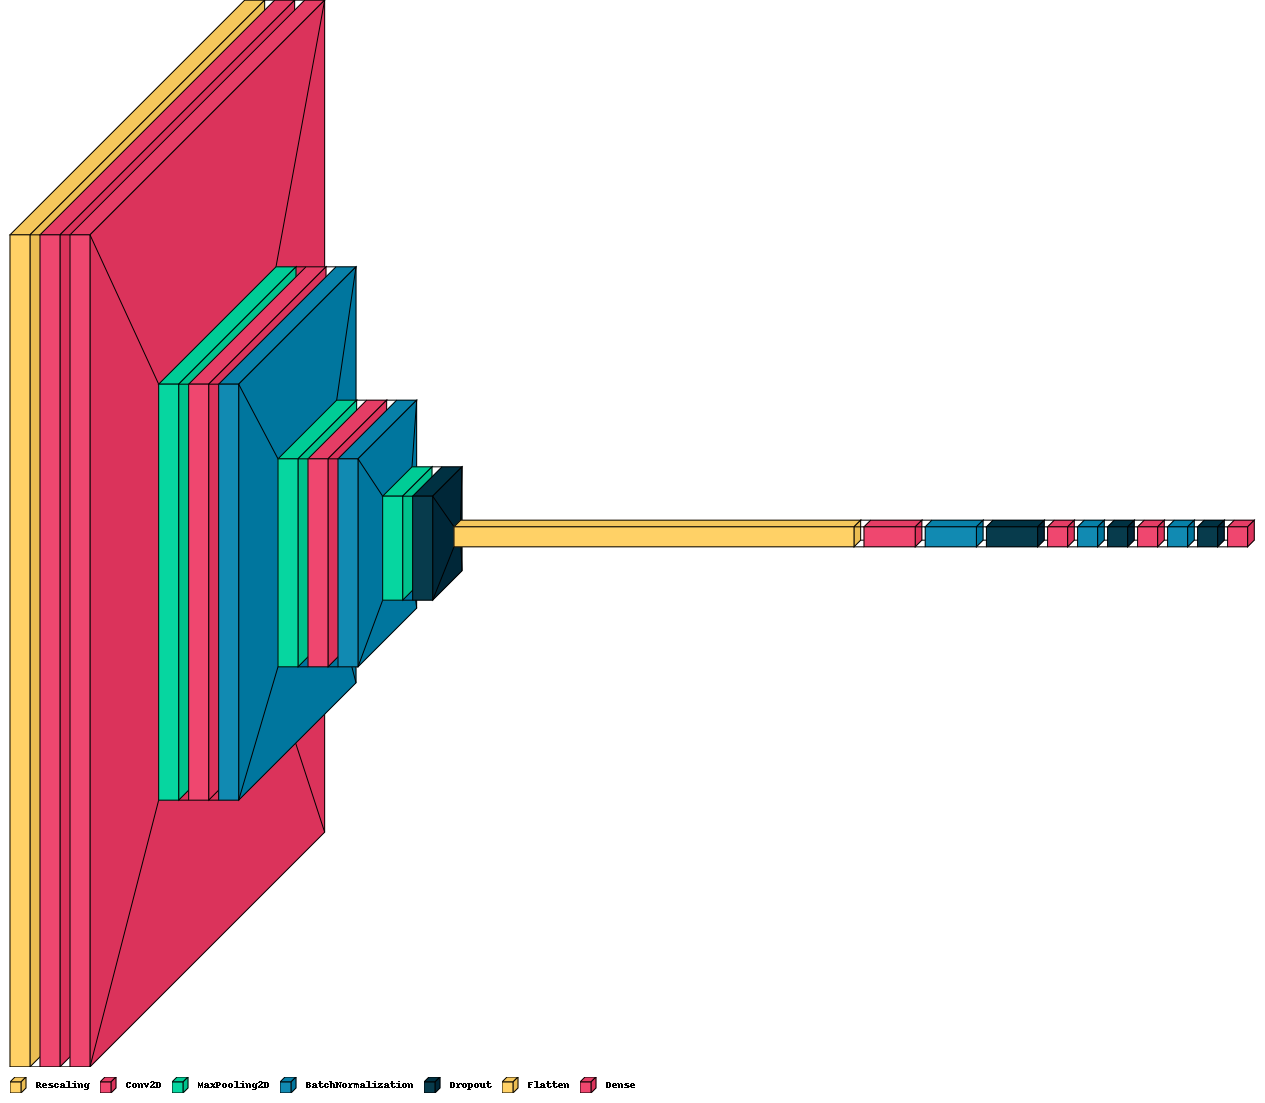

In [ ]:
visualkeras.layered_view(model_origin_ds, legend=True) 

# Training the models



## On Original Dataset

### Simple model

In [25]:
history_origin_ds_simple = model_origin_ds_simple.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lrng_rate_scheduler],
    epochs=EPOCHS
)

Epoch 1/30
257/257 [==============================] - 551s 2s/step - loss: 1.0026 - auc: 0.8219 - acc: 0.5433 - val_loss: 4.1759 - val_auc: 0.7214 - val_acc: 0.4756 - lr: 0.0100
Epoch 2/30
257/257 [==============================] - 7s 28ms/step - loss: 0.6932 - auc: 0.9129 - acc: 0.7003 - val_loss: 4.0379 - val_auc: 0.7600 - val_acc: 0.4658 - lr: 0.0089
Epoch 3/30
257/257 [==============================] - 7s 26ms/step - loss: 0.7606 - auc: 0.8951 - acc: 0.6610 - val_loss: 6.4625 - val_auc: 0.6761 - val_acc: 0.4980 - lr: 0.0079
Epoch 4/30
257/257 [==============================] - 8s 29ms/step - loss: 0.5391 - auc: 0.9467 - acc: 0.7732 - val_loss: 0.8585 - val_auc: 0.9036 - val_acc: 0.6553 - lr: 0.0071
Epoch 5/30
257/257 [==============================] - 7s 27ms/step - loss: 0.5228 - auc: 0.9504 - acc: 0.7835 - val_loss: 1.3780 - val_auc: 0.8137 - val_acc: 0.4609 - lr: 0.0063
Epoch 6/30
257/257 [==============================] - 7s 27ms/step - loss: 0.4190 - auc: 0.9678 - acc: 0.8316 

Accuracy and loss graph after each epoch

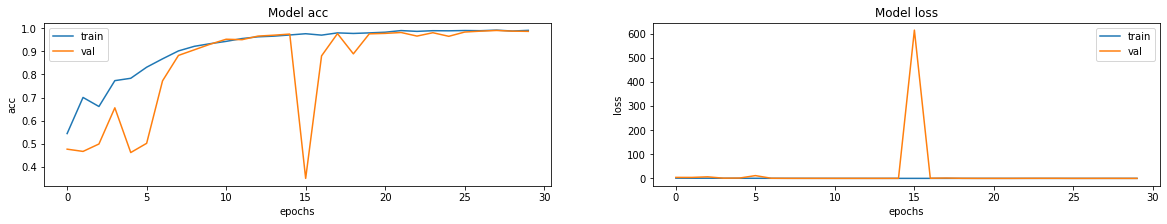

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history_origin_ds_simple.history[met])
    ax[i].plot(history_origin_ds_simple.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

AUC and loss graph after each epoch

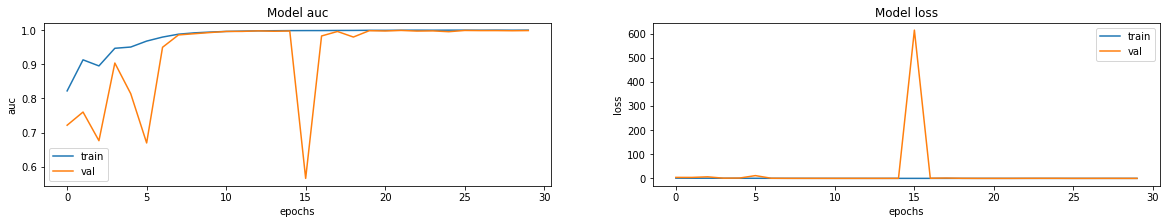

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history_origin_ds_simple.history[met])
    ax[i].plot(history_origin_ds_simple.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### More complexe model

In [ ]:
history_origin_ds = model_origin_ds.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lrng_rate_scheduler],
    epochs=EPOCHS
)

Epoch 1/30
257/257 [==============================] - 10s 33ms/step - loss: 1.0335 - auc: 0.8084 - acc: 0.5175 - val_loss: 7.2001 - val_auc: 0.6691 - val_acc: 0.4951 - lr: 0.0100
Epoch 2/30
257/257 [==============================] - 8s 31ms/step - loss: 0.8822 - auc: 0.8520 - acc: 0.5782 - val_loss: 0.7787 - val_auc: 0.8826 - val_acc: 0.6084 - lr: 0.0089
Epoch 3/30
257/257 [==============================] - 8s 29ms/step - loss: 0.7832 - auc: 0.8855 - acc: 0.6375 - val_loss: 17.7814 - val_auc: 0.6634 - val_acc: 0.4951 - lr: 0.0079
Epoch 4/30
257/257 [==============================] - 8s 32ms/step - loss: 0.6404 - auc: 0.9254 - acc: 0.7293 - val_loss: 0.4834 - val_auc: 0.9578 - val_acc: 0.8184 - lr: 0.0071
Epoch 5/30
257/257 [==============================] - 8s 32ms/step - loss: 0.5025 - auc: 0.9544 - acc: 0.7984 - val_loss: 0.4623 - val_auc: 0.9614 - val_acc: 0.8223 - lr: 0.0063
Epoch 6/30
257/257 [==============================] - 7s 28ms/step - loss: 0.4130 - auc: 0.9686 - acc: 0.839

Graph of the accuracy and loss after each epoch

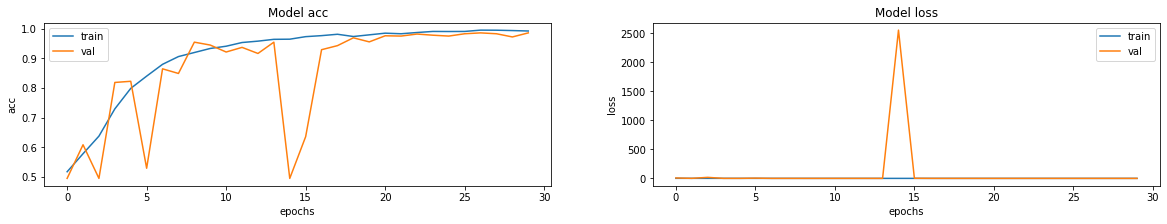

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history_origin_ds.history[met])
    ax[i].plot(history_origin_ds.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

Graph of the AUC and loss after each epoch

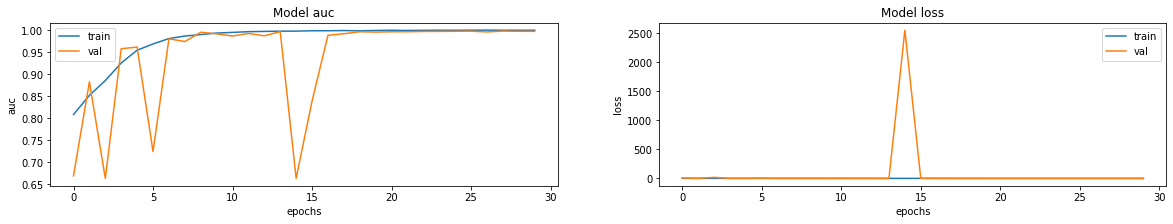

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history_origin_ds.history[met])
    ax[i].plot(history_origin_ds.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## On Downsampled Dataset

### Simple model

In [28]:
history_dwn_ds_simple = model_dwn_ds_simple.fit(
    dwn_train_ds,
    validation_data=dwn_val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lrng_rate_scheduler],
    epochs=EPOCHS
)

Epoch 1/30
111/111 [==============================] - 222s 2s/step - loss: 1.2326 - auc: 0.8922 - acc: 0.6509 - val_loss: 9.6676 - val_auc: 0.3661 - val_acc: 0.1341 - lr: 0.0100
Epoch 2/30
111/111 [==============================] - 3s 27ms/step - loss: 0.8654 - auc: 0.8643 - acc: 0.6211 - val_loss: 2.4931 - val_auc: 0.7079 - val_acc: 0.3523 - lr: 0.0089
Epoch 3/30
111/111 [==============================] - 3s 26ms/step - loss: 0.7384 - auc: 0.9018 - acc: 0.6835 - val_loss: 5.1229 - val_auc: 0.6355 - val_acc: 0.3136 - lr: 0.0079
Epoch 4/30
111/111 [==============================] - 3s 27ms/step - loss: 0.4923 - auc: 0.9562 - acc: 0.8049 - val_loss: 0.6154 - val_auc: 0.9369 - val_acc: 0.7500 - lr: 0.0071
Epoch 5/30
111/111 [==============================] - 3s 27ms/step - loss: 0.3650 - auc: 0.9754 - acc: 0.8525 - val_loss: 1.3490 - val_auc: 0.8512 - val_acc: 0.5864 - lr: 0.0063
Epoch 6/30
111/111 [==============================] - 3s 26ms/step - loss: 0.2523 - auc: 0.9877 - acc: 0.9036 

Accuracy and loss graph after each epoch

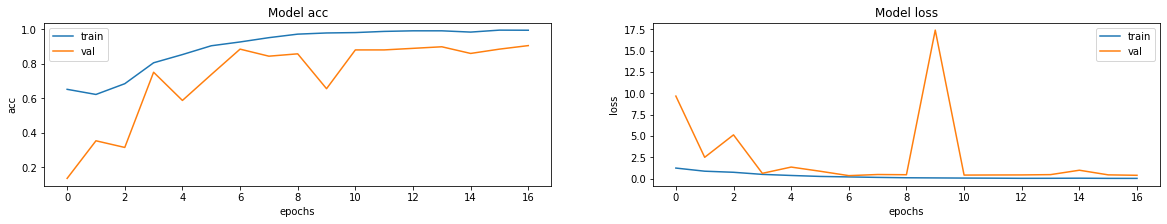

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history_dwn_ds_simple.history[met])
    ax[i].plot(history_dwn_ds_simple.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

AUC and loss graph after each epoch

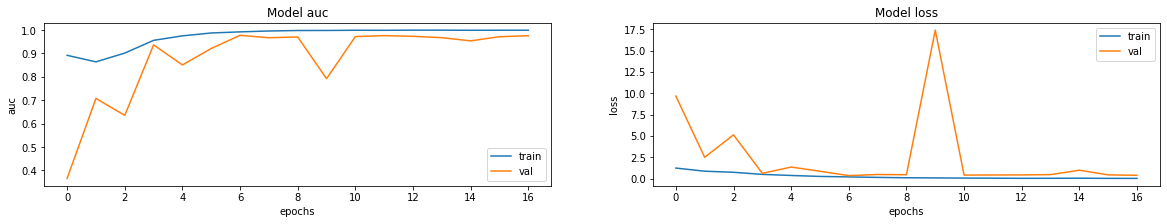

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history_dwn_ds_simple.history[met])
    ax[i].plot(history_dwn_ds_simple.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### More complexe model

In [ ]:
history_dwn_ds = model_dwn_ds.fit(
    dwn_train_ds,
    validation_data=dwn_val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lrng_rate_scheduler],
    epochs=EPOCHS
)

Epoch 1/30
111/111 [==============================] - 6s 34ms/step - loss: 1.3282 - auc: 0.8749 - acc: 0.6179 - val_loss: 28.4824 - val_auc: 0.5432 - val_acc: 0.3136 - lr: 0.0100
Epoch 2/30
111/111 [==============================] - 3s 30ms/step - loss: 1.0861 - auc: 0.7806 - acc: 0.5003 - val_loss: 1.9203 - val_auc: 0.6741 - val_acc: 0.3386 - lr: 0.0089
Epoch 3/30
111/111 [==============================] - 3s 30ms/step - loss: 1.0147 - auc: 0.8093 - acc: 0.5281 - val_loss: 1.1188 - val_auc: 0.7598 - val_acc: 0.4545 - lr: 0.0079
Epoch 4/30
111/111 [==============================] - 3s 29ms/step - loss: 0.9803 - auc: 0.8238 - acc: 0.5604 - val_loss: 1.1880 - val_auc: 0.7345 - val_acc: 0.4000 - lr: 0.0071
Epoch 5/30
111/111 [==============================] - 3s 30ms/step - loss: 0.8939 - auc: 0.8539 - acc: 0.6103 - val_loss: 1.1126 - val_auc: 0.8051 - val_acc: 0.4977 - lr: 0.0063
Epoch 6/30
111/111 [==============================] - 3s 30ms/step - loss: 0.7970 - auc: 0.8824 - acc: 0.6324

Graph of the accuracy and loss after each epoch

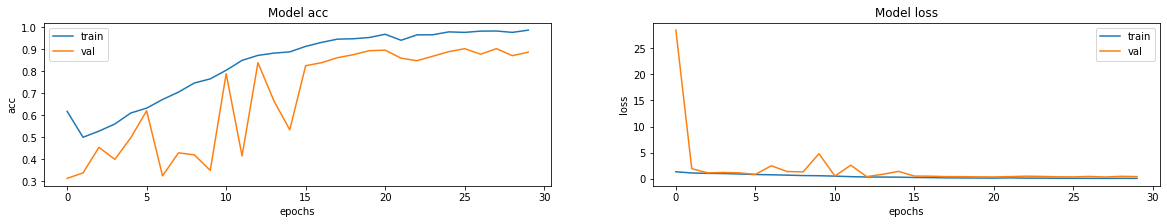

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history_dwn_ds.history[met])
    ax[i].plot(history_dwn_ds.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

Graph of the AUC and loss after each epoch

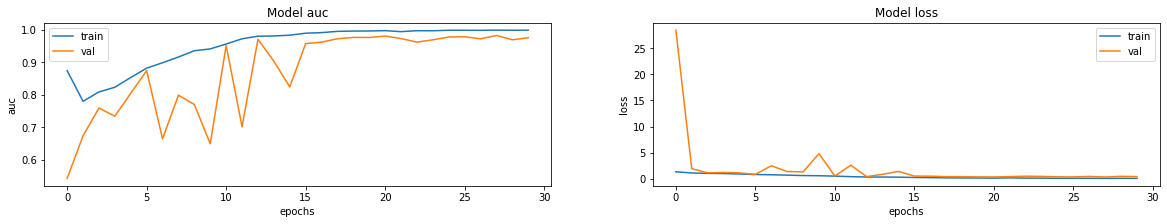

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history_dwn_ds.history[met])
    ax[i].plot(history_dwn_ds.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## On Oversampled Dataset

### Simple model

In [31]:
history_ovr_ds_simple = model_ovr_ds_simple.fit(
    ovr_train_ds,
    validation_data=ovr_val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lrng_rate_scheduler],
    epochs=EPOCHS
)

Epoch 1/30
309/309 [==============================] - 620s 2s/step - loss: 0.9301 - auc: 0.8611 - acc: 0.6004 - val_loss: 0.9353 - val_auc: 0.8792 - val_acc: 0.6067 - lr: 0.0100
Epoch 2/30
309/309 [==============================] - 8s 26ms/step - loss: 0.5894 - auc: 0.9371 - acc: 0.7430 - val_loss: 0.9042 - val_auc: 0.9076 - val_acc: 0.7405 - lr: 0.0089
Epoch 3/30
309/309 [==============================] - 8s 26ms/step - loss: 0.4062 - auc: 0.9701 - acc: 0.8394 - val_loss: 1.1460 - val_auc: 0.9082 - val_acc: 0.6642 - lr: 0.0079
Epoch 4/30
309/309 [==============================] - 8s 27ms/step - loss: 0.2931 - auc: 0.9835 - acc: 0.8861 - val_loss: 0.2436 - val_auc: 0.9887 - val_acc: 0.9011 - lr: 0.0071
Epoch 5/30
309/309 [==============================] - 8s 27ms/step - loss: 0.2163 - auc: 0.9908 - acc: 0.9143 - val_loss: 0.2214 - val_auc: 0.9904 - val_acc: 0.9181 - lr: 0.0063
Epoch 6/30
309/309 [==============================] - 9s 28ms/step - loss: 0.1585 - auc: 0.9949 - acc: 0.9406 

Accuracy and loss graph after each epoch

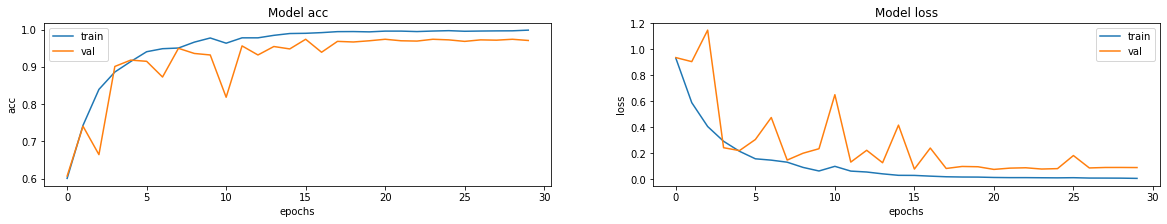

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history_ovr_ds_simple.history[met])
    ax[i].plot(history_ovr_ds_simple.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

AUC and loss graph after each epoch

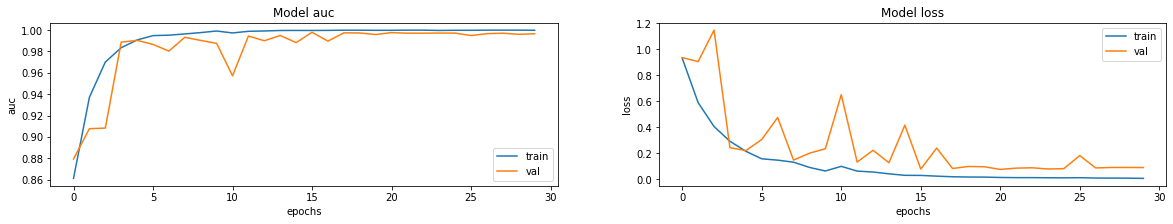

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history_ovr_ds_simple.history[met])
    ax[i].plot(history_ovr_ds_simple.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### More complex model

In [ ]:
history_ovr_ds = model_ovr_ds.fit(
    ovr_train_ds,
    validation_data=ovr_val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lrng_rate_scheduler],
    epochs=EPOCHS
)

Epoch 1/30
309/309 [==============================] - 854s 3s/step - loss: 1.0061 - auc: 0.8170 - acc: 0.5254 - val_loss: 5.5914 - val_auc: 0.5190 - val_acc: 0.2628 - lr: 0.0100
Epoch 2/30
309/309 [==============================] - 9s 30ms/step - loss: 0.8617 - auc: 0.8564 - acc: 0.5792 - val_loss: 3.8672 - val_auc: 0.6673 - val_acc: 0.4582 - lr: 0.0089
Epoch 3/30
309/309 [==============================] - 9s 30ms/step - loss: 0.8062 - auc: 0.8774 - acc: 0.6223 - val_loss: 2.4148 - val_auc: 0.6808 - val_acc: 0.3593 - lr: 0.0079
Epoch 4/30
309/309 [==============================] - 9s 30ms/step - loss: 0.6817 - auc: 0.9141 - acc: 0.6882 - val_loss: 0.6828 - val_auc: 0.9235 - val_acc: 0.6951 - lr: 0.0071
Epoch 5/30
309/309 [==============================] - 9s 29ms/step - loss: 0.5813 - auc: 0.9389 - acc: 0.7456 - val_loss: 1.1346 - val_auc: 0.8297 - val_acc: 0.5588 - lr: 0.0063
Epoch 6/30
309/309 [==============================] - 10s 31ms/step - loss: 0.4967 - auc: 0.9556 - acc: 0.7916

Graph of the accuracy and loss after each epoch

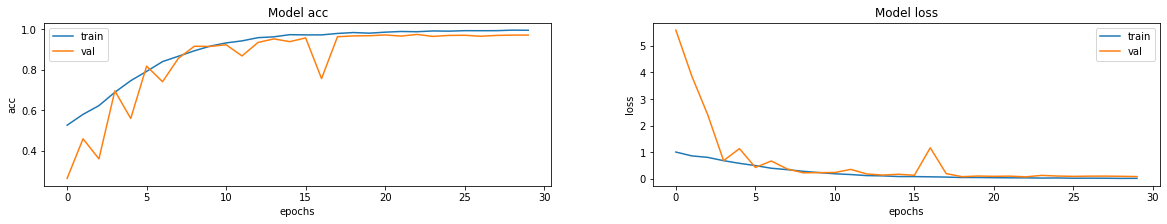

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history_ovr_ds.history[met])
    ax[i].plot(history_ovr_ds.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

Graph of the AUC and loss after each epoch

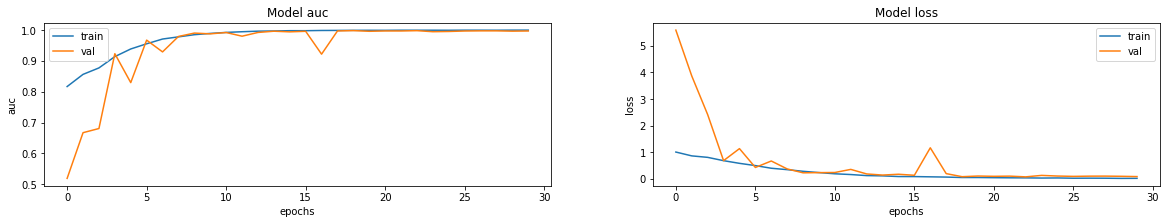

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history_ovr_ds.history[met])
    ax[i].plot(history_ovr_ds.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# Evaluate the model


Preprocessiong of the images from the test directory

In [34]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_origin_ds+"test/",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1279 files belonging to 4 classes.


## For the original dataset

### Simple model

In [35]:
model_origin_ds_simple.evaluate(test_ds)
pred = model_origin_ds_simple.predict(test_ds)

80/80 [==============================] - 100s 1s/step - loss: 1.9111 - auc: 0.8356 - acc: 0.6114


                  precision    recall  f1-score   support

    MildDementia       0.48      0.23      0.31       179
ModerateDementia       1.00      0.08      0.15        12
     NonDementia       0.67      0.71      0.69       640
VeryMildDementia       0.56      0.64      0.60       448

        accuracy                           0.61      1279
       macro avg       0.68      0.41      0.44      1279
    weighted avg       0.61      0.61      0.60      1279



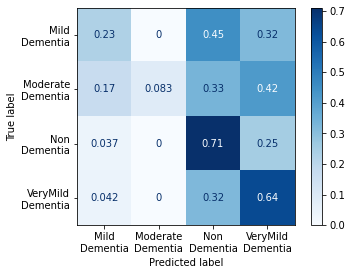

In [36]:
test_ds = test_ds.map(rev_one_hot_label, num_parallel_calls=AUTOTUNE)
y_true = tf.concat([y for x, y in test_ds], axis=0)
y_pred = np.argmax(pred,axis=1)
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, 
                                        display_labels = ['Mild\nDementia', 'Moderate\nDementia', 'Non\nDementia', 'VeryMild\nDementia'], 
                                        cmap='Blues', normalize = 'true')
print(classification_report(y_true, y_pred, target_names=class_names))
test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

### Complexe model

In [ ]:
model_origin_ds.evaluate(test_ds)
pred = model_origin_ds.predict(test_ds)

80/80 [==============================] - 4s 33ms/step - loss: 2.1457 - auc: 0.8185 - acc: 0.6075


                  precision    recall  f1-score   support

    MildDementia       0.52      0.35      0.42       179
ModerateDementia       0.50      0.17      0.25        12
     NonDementia       0.84      0.51      0.64       640
VeryMildDementia       0.50      0.85      0.63       448

        accuracy                           0.61      1279
       macro avg       0.59      0.47      0.48      1279
    weighted avg       0.67      0.61      0.60      1279



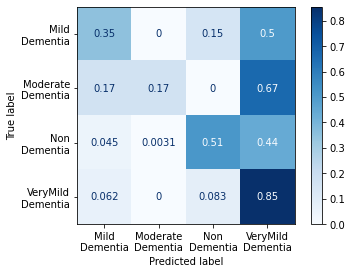

In [ ]:
test_ds = test_ds.map(rev_one_hot_label, num_parallel_calls=AUTOTUNE)
y_true = tf.concat([y for x, y in test_ds], axis=0)
y_pred = np.argmax(pred,axis=1)
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, 
                                        display_labels = ['Mild\nDementia', 'Moderate\nDementia', 'Non\nDementia', 'VeryMild\nDementia'], 
                                        cmap='Blues', normalize = 'true')
print(classification_report(y_true, y_pred, target_names=class_names))
test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

## For the downsampled dataset

### Simple model

In [37]:
model_dwn_ds_simple.evaluate(test_ds)
pred = model_dwn_ds_simple.predict(test_ds)

80/80 [==============================] - 1s 8ms/step - loss: 1.3524 - auc: 0.8389 - acc: 0.6099


                  precision    recall  f1-score   support

    MildDementia       0.47      0.27      0.34       179
ModerateDementia       1.00      0.17      0.29        12
     NonDementia       0.62      0.88      0.72       640
VeryMildDementia       0.64      0.38      0.48       448

        accuracy                           0.61      1279
       macro avg       0.68      0.42      0.46      1279
    weighted avg       0.61      0.61      0.58      1279



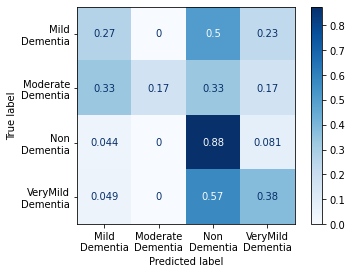

In [38]:
test_ds = test_ds.map(rev_one_hot_label, num_parallel_calls=AUTOTUNE)
y_true = tf.concat([y for x, y in test_ds], axis=0)
y_pred = np.argmax(pred,axis=1)
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, 
                                        display_labels = ['Mild\nDementia', 'Moderate\nDementia', 'Non\nDementia', 'VeryMild\nDementia'], 
                                        cmap='Blues', normalize = 'true')
print(classification_report(y_true, y_pred, target_names=class_names))
test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

### Complexe model

In [ ]:
model_dwn_ds.evaluate(test_ds)
pred = model_dwn_ds.predict(test_ds)

80/80 [==============================] - 1s 9ms/step - loss: 1.4313 - auc: 0.8447 - acc: 0.6208


                  precision    recall  f1-score   support

    MildDementia       0.45      0.44      0.44       179
ModerateDementia       1.00      0.33      0.50        12
     NonDementia       0.76      0.62      0.68       640
VeryMildDementia       0.55      0.71      0.62       448

        accuracy                           0.62      1279
       macro avg       0.69      0.52      0.56      1279
    weighted avg       0.64      0.62      0.62      1279



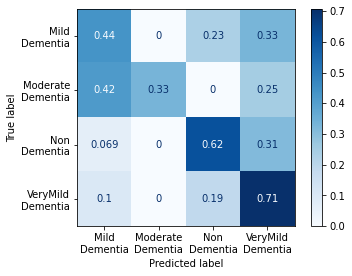

In [ ]:
test_ds = test_ds.map(rev_one_hot_label, num_parallel_calls=AUTOTUNE)
y_true = tf.concat([y for x, y in test_ds], axis=0)
y_pred = np.argmax(pred,axis=1)
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, 
                                        display_labels = ['Mild\nDementia', 'Moderate\nDementia', 'Non\nDementia', 'VeryMild\nDementia'], 
                                        cmap='Blues', normalize = 'true')
print(classification_report(y_true, y_pred, target_names=class_names))
test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

## For the oversampled dataset

### Simple model

In [39]:
model_ovr_ds_simple.evaluate(test_ds)
pred = model_ovr_ds_simple.predict(test_ds)

80/80 [==============================] - 1s 8ms/step - loss: 2.4369 - auc: 0.7790 - acc: 0.5653


                  precision    recall  f1-score   support

    MildDementia       0.40      0.45      0.42       179
ModerateDementia       0.41      0.58      0.48        12
     NonDementia       0.74      0.47      0.58       640
VeryMildDementia       0.51      0.74      0.61       448

        accuracy                           0.57      1279
       macro avg       0.52      0.56      0.52      1279
    weighted avg       0.61      0.57      0.56      1279



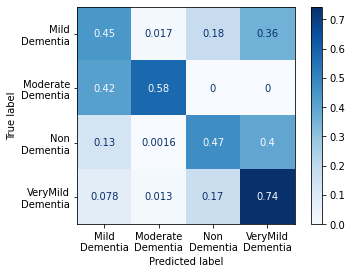

In [40]:
test_ds = test_ds.map(rev_one_hot_label, num_parallel_calls=AUTOTUNE)
y_true = tf.concat([y for x, y in test_ds], axis=0)
y_pred = np.argmax(pred,axis=1)
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, 
                                        display_labels = ['Mild\nDementia', 'Moderate\nDementia', 'Non\nDementia', 'VeryMild\nDementia'], 
                                        cmap='Blues', normalize = 'true')
print(classification_report(y_true, y_pred, target_names=class_names))
test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

### Complexe mode

In [ ]:
model_ovr_ds.evaluate(test_ds)
pred = model_ovr_ds.predict(test_ds)

80/80 [==============================] - 91s 1s/step - loss: 1.7881 - auc: 0.8237 - acc: 0.6239


                  precision    recall  f1-score   support

    MildDementia       0.38      0.39      0.38       179
ModerateDementia       0.17      0.50      0.26        12
     NonDementia       0.80      0.65      0.72       640
VeryMildDementia       0.57      0.68      0.62       448

        accuracy                           0.62      1279
       macro avg       0.48      0.56      0.49      1279
    weighted avg       0.65      0.62      0.63      1279



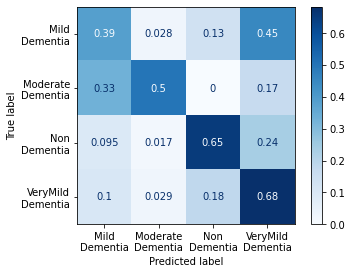

In [ ]:
test_ds = test_ds.map(rev_one_hot_label, num_parallel_calls=AUTOTUNE)
y_true = tf.concat([y for x, y in test_ds], axis=0)
y_pred = np.argmax(pred,axis=1)
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, 
                                        display_labels = ['Mild\nDementia', 'Moderate\nDementia', 'Non\nDementia', 'VeryMild\nDementia'], 
                                        cmap='Blues', normalize = 'true')
print(classification_report(y_true, y_pred, target_names=class_names))
test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

# VGG16

Importing the VGG16 model

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model


vgg = VGG16(include_top=False, 
                     weights = 'imagenet',
                     pooling = 'avg',
                     input_shape = IMAGE_SIZE + [3], 
                     classes = 4)

for layer in vgg.layers:
  layer.trainable = False

x = tf.keras.layers.Flatten()(vgg.output)
x = tf.keras.layers.Dense(units = 1024, activation = "relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
prediction = tf.keras.layers.Dense(NUM_CLASSES,activation = "softmax")(x)

model_vgg16 = Model(inputs = vgg.input,outputs = prediction)

model_vgg16.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = METRICS)

model_vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 176, 208, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 176, 208, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 176, 208, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 88, 104, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 88, 104, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 88, 104, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 44, 52, 128)       0     

Fitting the VGG16 model

In [ ]:

es = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history_vgg16 = model_vgg16.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, es, lrng_rate_scheduler],
    epochs=EPOCHS
)


Epoch 1/30
257/257 [==============================] - 23s 81ms/step - loss: 1.2785 - auc: 0.8115 - acc: 0.5562 - val_loss: 1.2047 - val_auc: 0.8343 - val_acc: 0.5879 - lr: 0.0100
Epoch 2/30
257/257 [==============================] - 19s 75ms/step - loss: 0.9308 - auc: 0.8635 - acc: 0.6102 - val_loss: 1.3500 - val_auc: 0.8302 - val_acc: 0.5479 - lr: 0.0089
Epoch 3/30
257/257 [==============================] - 19s 75ms/step - loss: 0.7872 - auc: 0.8912 - acc: 0.6568 - val_loss: 0.8326 - val_auc: 0.8793 - val_acc: 0.6143 - lr: 0.0079
Epoch 4/30
257/257 [==============================] - 19s 75ms/step - loss: 0.7095 - auc: 0.9089 - acc: 0.6895 - val_loss: 0.7889 - val_auc: 0.8916 - val_acc: 0.6553 - lr: 0.0071
Epoch 5/30
257/257 [==============================] - 19s 76ms/step - loss: 0.6774 - auc: 0.9165 - acc: 0.7054 - val_loss: 0.7741 - val_auc: 0.8946 - val_acc: 0.6641 - lr: 0.0063
Epoch 6/30
257/257 [==============================] - 20s 76ms/step - loss: 0.6450 - auc: 0.9238 - acc: 0

Accuracy and loss graphs

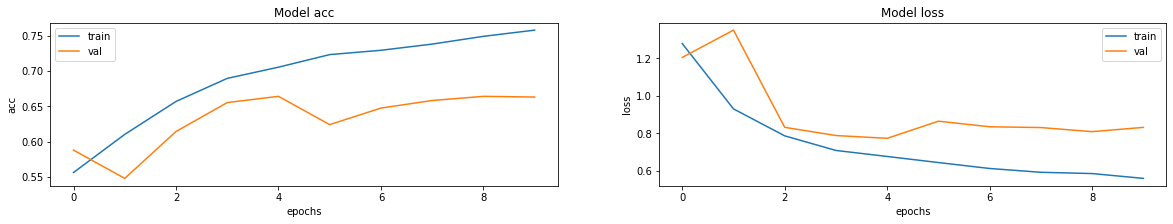

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history_vgg16.history[met])
    ax[i].plot(history_vgg16.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

AUC and loss graphs

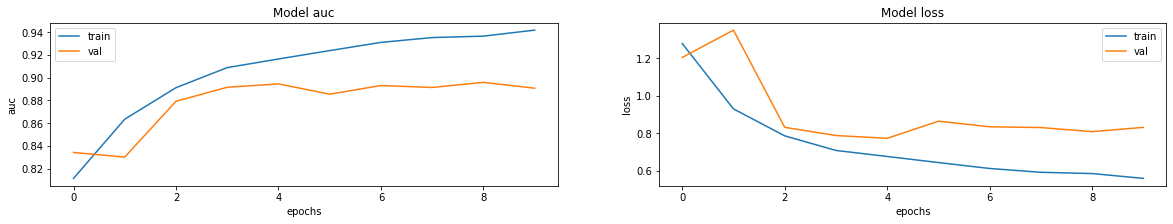

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history_vgg16.history[met])
    ax[i].plot(history_vgg16.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

Evaluating the VGG16 model

In [ ]:
model_vgg16.evaluate(test_ds)
pred = model_vgg16.predict(test_ds)

80/80 [==============================] - 6s 77ms/step - loss: 1.2041 - auc: 0.8064 - acc: 0.5285


                  precision    recall  f1-score   support

    MildDementia       0.39      0.06      0.11       179
ModerateDementia       0.10      0.50      0.17        12
     NonDementia       0.69      0.53      0.60       640
VeryMildDementia       0.46      0.72      0.56       448

        accuracy                           0.53      1279
       macro avg       0.41      0.45      0.36      1279
    weighted avg       0.56      0.53      0.51      1279



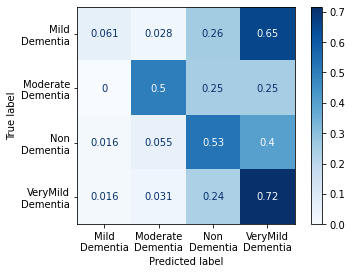

In [ ]:
test_ds = test_ds.map(rev_one_hot_label, num_parallel_calls=AUTOTUNE)
y_true = tf.concat([y for x, y in test_ds], axis=0)
y_pred = np.argmax(pred,axis=1)
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, 
                                        display_labels = ['Mild\nDementia', 'Moderate\nDementia', 'Non\nDementia', 'VeryMild\nDementia'], 
                                        cmap='Blues', normalize = 'true')
print(classification_report(y_true, y_pred, target_names=class_names))
test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

# Resnet50

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model


resnet = ResNet50(include_top=False, 
                     weights = 'imagenet',
                     pooling = 'avg',
                     input_shape = IMAGE_SIZE + [3], 
                     classes = 4)

for layer in resnet.layers:
  layer.trainable = False

x = tf.keras.layers.Flatten()(resnet.output)
x = tf.keras.layers.Dense(units = 1024, activation = "relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
prediction_resnet = tf.keras.layers.Dense(NUM_CLASSES,activation = "softmax")(x)

model_resnet = Model(inputs = resnet.input,outputs = prediction_resnet)

model_resnet.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = METRICS)

model_resnet.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 176, 208, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 182, 214, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 88, 104, 64)  9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalizati

Fitting the ResNet50 model

In [ ]:
history_resnet = model_resnet.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, es, lrng_rate_scheduler],
    epochs=EPOCHS
)

Epoch 1/30
257/257 [==============================] - 20s 61ms/step - loss: 1.3122 - auc: 0.8055 - acc: 0.5363 - val_loss: 3.0109 - val_auc: 0.7476 - val_acc: 0.5078 - lr: 0.0100
Epoch 2/30
257/257 [==============================] - 14s 54ms/step - loss: 0.9410 - auc: 0.8662 - acc: 0.6178 - val_loss: 0.8142 - val_auc: 0.8904 - val_acc: 0.6514 - lr: 0.0089
Epoch 3/30
257/257 [==============================] - 14s 53ms/step - loss: 0.7524 - auc: 0.9025 - acc: 0.6864 - val_loss: 0.8947 - val_auc: 0.8873 - val_acc: 0.6387 - lr: 0.0079
Epoch 4/30
257/257 [==============================] - 14s 53ms/step - loss: 0.6583 - auc: 0.9222 - acc: 0.7159 - val_loss: 0.8192 - val_auc: 0.9039 - val_acc: 0.6650 - lr: 0.0071
Epoch 5/30
257/257 [==============================] - 14s 53ms/step - loss: 0.5878 - auc: 0.9376 - acc: 0.7501 - val_loss: 1.0241 - val_auc: 0.8854 - val_acc: 0.6455 - lr: 0.0063
Epoch 6/30
257/257 [==============================] - 14s 54ms/step - loss: 0.5270 - auc: 0.9495 - acc: 0

Accuracy and loss graphs

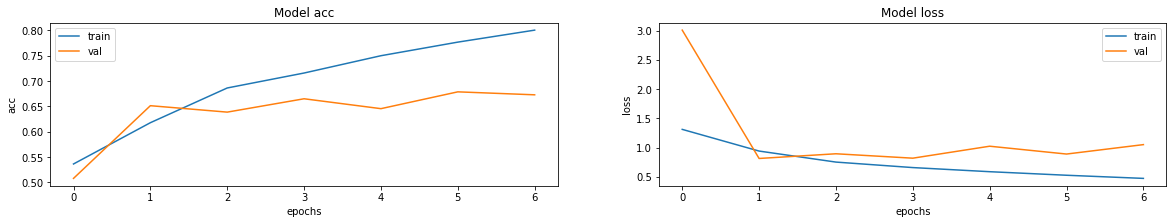

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history_resnet.history[met])
    ax[i].plot(history_resnet.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

AUC and loss graphs

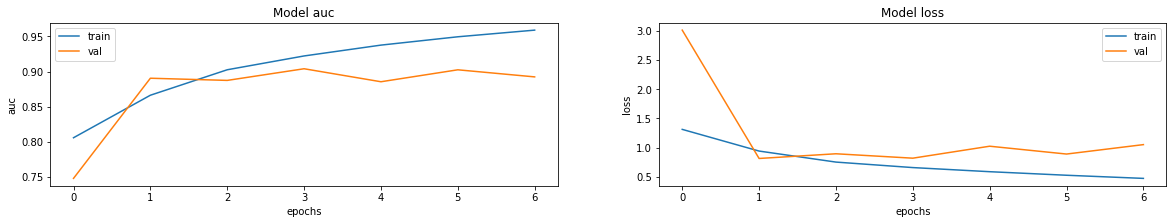

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history_resnet.history[met])
    ax[i].plot(history_resnet.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

Evaluating the model

In [ ]:
model_resnet.evaluate(test_ds)
pred = model_resnet.predict(test_ds)

80/80 [==============================] - 4s 49ms/step - loss: 1.0423 - auc: 0.8277 - acc: 0.5582


                  precision    recall  f1-score   support

    MildDementia       0.62      0.15      0.24       179
ModerateDementia       0.09      0.58      0.16        12
     NonDementia       0.65      0.69      0.67       640
VeryMildDementia       0.49      0.53      0.51       448

        accuracy                           0.56      1279
       macro avg       0.46      0.49      0.39      1279
    weighted avg       0.59      0.56      0.55      1279



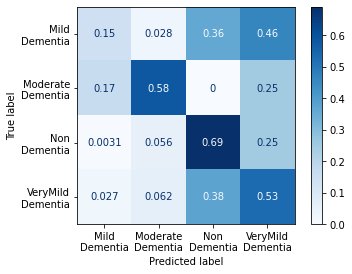

In [ ]:
test_ds = test_ds.map(rev_one_hot_label, num_parallel_calls=AUTOTUNE)
y_true = tf.concat([y for x, y in test_ds], axis=0)
y_pred = np.argmax(pred,axis=1)
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, 
                                        display_labels = ['Mild\nDementia', 'Moderate\nDementia', 'Non\nDementia', 'VeryMild\nDementia'], 
                                        cmap='Blues', normalize = 'true')
print(classification_report(y_true, y_pred, target_names=class_names))
test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)